### aim: Code to produce spatial climatologies

### associated extraction scripts? none

In [137]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [138]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = False
plt.rc('font', **font)

## tutorial on how to get the fonts i want

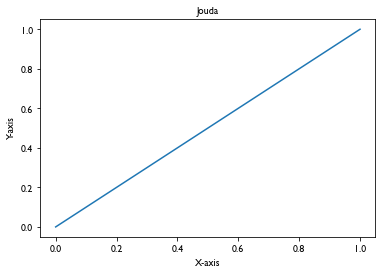

In [140]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import rcParams
plt.rcParams['text.usetex'] = False
plt.rc('font', **font)

fs = 10
# Set global font size
rcParams.update({
    'font.size': fs,            # Base font size
    'axes.titlesize': fs,       # Title size
    'axes.labelsize': fs,       # X/Y label size
    'xtick.labelsize': fs,      # X-axis tick label
    'ytick.labelsize': fs,      # Y-axis tick label
    'legend.fontsize': fs,      # Legend text
})


# Your Gill Sans font file
gill_sans_path = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"

# Register the font
gill_font = font_manager.FontProperties(fname=gill_sans_path)
font_manager.fontManager.addfont(gill_sans_path)

# Get internal name (important for mathtext settings)
gill_font_name = font_manager.FontProperties(fname=gill_sans_path).get_name()

# Set mathtext to use your font
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = gill_font_name
rcParams['mathtext.it'] = gill_font_name
rcParams['mathtext.bf'] = gill_font_name




# Specify the paths to the gill Sans font files
gill_sans = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"
# Create FontProperties object
gill_font = font_manager.FontProperties(fname=gill_sans)

# Sample plot
fig, ax = plt.subplots()
fs = 14

ax.plot([0, 1], [0, 1])

# Apply font to specific labels
ax.set_title("Jouda", fontproperties=gill_font)
ax.set_xlabel("X-axis", fontproperties=gill_font)
ax.set_ylabel("Y-axis", fontproperties=gill_font)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(gill_font)

plt.show()

### ukesm - average 3 ensemble members to get UKESMEM daily_standard product

In [141]:
tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESM3M/'
tdir2 = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESM/'

ex = False

if ex:
    for y in range(1950,2021):

        print(y)

        w = xr.open_dataset(f'{tdir}/scen1B_UKESM_wind_daily_1x1_{y}.nc')
        w2 = xr.open_dataset(f'{tdir}/scen1BM2_UKESM_wind_daily_1x1_{y}.nc')
        w3 = xr.open_dataset(f'{tdir}/scen1BM3_UKESM_wind_daily_1x1_{y}.nc')

        wspd10m_avg = (w['wspd10m'] + w2['wspd10m'] + w3['wspd10m']) / 3
        u10m_avg = (w['u10m'] + w2['u10m'] + w3['u10m']) / 3
        v10m_avg = (w['v10m'] + w2['v10m'] + w3['v10m']) / 3

        d4 = xr.Dataset({'wspd10m': wspd10m_avg,\
                        'u10m': u10m_avg,\
                        'v10m': v10m_avg,})

        d4['wspd10m'].attrs = w['wspd10m'].attrs
        d4['u10m'].attrs = w['u10m'].attrs
        d4['v10m'].attrs = w['v10m'].attrs
        td = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESMEM/'
        d4.to_netcdf(f'{td}/UKESMEM_wind_daily_1x1_{y}.nc')

## make em1 em2 em3 ukesm symlinks

In [8]:
tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESM3M/'
tdir2 = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESM/'

ex = False

import os

if ex:
    
    for y in range(1950,2021):
        s1 = f'/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESM3M/scen1BM2_UKESM_wind_daily_1x1_{y}.nc'
        s2 = f'/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESMm2/UKESMm2_wind_daily_1x1_{y}.nc'
        try:
            os.symlink(s1, s2)
        except:
            print(f'no for UKESMm2 {y}')

    for y in range(1950,2021):
        s1 = f'/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESM3M/scen1BM3_UKESM_wind_daily_1x1_{y}.nc'
        s2 = f'/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESMm3/UKESMm3_wind_daily_1x1_{y}.nc'
        try:
            os.symlink(s1, s2)
        except:
            print(f'no for UKESMm3 {y}')

### visualise ensemble mean 

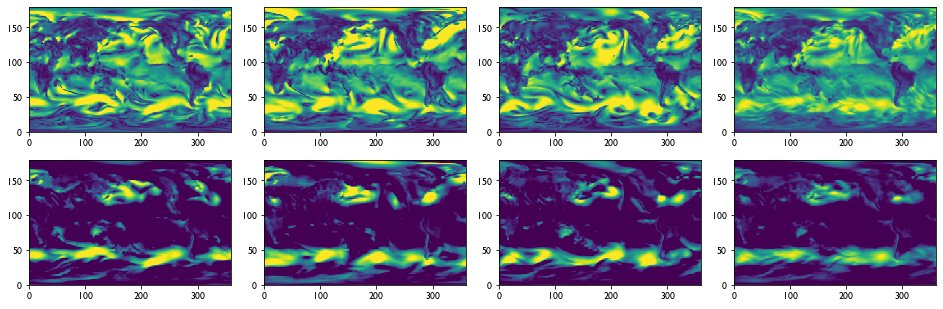

In [142]:
vis = True
if vis:
    y = 2020
    td = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESMEM/'

    fact = 1.1
    fig, axs = plt.subplots(2,4, figsize=(12*fact, 4*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    w = xr.open_dataset(f'{tdir}/scen1B_UKESM_wind_daily_1x1_{y}.nc')
    w2 = xr.open_dataset(f'{tdir}/scen1BM2_UKESM_wind_daily_1x1_{y}.nc')
    w3 = xr.open_dataset(f'{tdir}/scen1BM3_UKESM_wind_daily_1x1_{y}.nc')
    we = xr.open_dataset(f'{td}/UKESMEM_wind_daily_1x1_{y}.nc')

    axs[0].pcolormesh(w.wspd10m[0,:,:], vmin = 0, vmax = 12)
    axs[1].pcolormesh(w2.wspd10m[0,:,:], vmin = 0, vmax = 12)
    axs[2].pcolormesh(w3.wspd10m[0,:,:], vmin = 0, vmax = 12)
    axs[3].pcolormesh(we.wspd10m[0,:,:], vmin = 0, vmax = 12)

    axs[0+4].pcolormesh(w.u10m[0,:,:], vmin = 0, vmax = 12)
    axs[1+4].pcolormesh(w2.u10m[0,:,:], vmin = 0, vmax = 12)
    axs[2+4].pcolormesh(w3.u10m[0,:,:], vmin = 0, vmax = 12)
    axs[3+4].pcolormesh(we.u10m[0,:,:], vmin = 0, vmax = 12)
    
for ax in axs:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(gill_font)

plt.tight_layout()

## make seasonal averages for producsts (and UKESMEM)

In [143]:
ex = False

def make_yearlist(yrst, yrend, prod, \
                 baseDir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{prod}/{prod}_wind_daily_1x1_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'

if ex:
    
    # ncar = xr.open_mfdataset(make_yearlist(1980, 2019, 'NCEP-NCAR'))
    # doe = xr.open_mfdataset(make_yearlist(1980, 2019, 'NCEP-DOE'))
    # era = xr.open_mfdataset(make_yearlist(1980, 2019, 'ERA5'))
    ukesm = xr.open_mfdataset(make_yearlist(1980, 2019, 'UKESMEM'))
    # merra = xr.open_mfdataset(make_yearlist(1980, 2019, 'MERRA'))
    #ukesm_nz = xr.open_mfdataset(make_yearlist(1980, 2019, 'UKESM_NOZONE'))
    # jra = xr.open_mfdataset(make_yearlist(1980, 2019, 'JRA'))

    # tvs = ['NCEP-DOE','NCEP-NCAR','ERA5','UKESM','MERRA']
    # tds = [doe, ncar, era, ukesm, merra]
    
    tvs = ['UKESMEM']
    tds = [ukesm]
    

    
    for i in range(0,len(tvs)):
        
        tv = tvs[i]
        td = tds[i]
        print(f'{tv} making machine')
    
        tddjf = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).mean(dim = ['time_counter'])
        tdjja = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).mean(dim = ['time_counter'])
        tdmam = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'MAM')).mean(dim = ['time_counter'])
        tdson = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'SON')).mean(dim = ['time_counter'])
        tdfy = td.wspd10m.mean(dim = ['time_counter'])

        tddjf.to_netcdf(f'{sdir}/{tv}_djf_1980-2019.nc')
        tdjja.to_netcdf(f'{sdir}/{tv}_jja_1980-2019.nc')
        tdmam.to_netcdf(f'{sdir}/{tv}_mam_1980-2019.nc')
        tdson.to_netcdf(f'{sdir}/{tv}_son_1980-2019.nc')
        tdfy.to_netcdf(f'{sdir}/{tv}_fy_1980-2019.nc')


## FIG-SPAT-CLIM CODE make maps of 1980-2019 clim the same way as fig-spatialtrends

In [144]:
merradjf = xr.open_dataset(f'{sdir}/MERRA_djf_1980-2019.nc')
merrajja = xr.open_dataset(f'{sdir}/MERRA_jja_1980-2019.nc')
merrason = xr.open_dataset(f'{sdir}/MERRA_son_1980-2019.nc')
merramam = xr.open_dataset(f'{sdir}/MERRA_mam_1980-2019.nc')
merrafy = xr.open_dataset(f'{sdir}/MERRA_fy_1980-2019.nc')

ncardjf = xr.open_dataset(f'{sdir}/NCEP-NCAR_djf_1980-2019.nc')
ncarjja = xr.open_dataset(f'{sdir}/NCEP-NCAR_jja_1980-2019.nc')
ncarson = xr.open_dataset(f'{sdir}/NCEP-NCAR_son_1980-2019.nc')
ncarmam = xr.open_dataset(f'{sdir}/NCEP-NCAR_mam_1980-2019.nc')
ncarfy = xr.open_dataset(f'{sdir}/NCEP-NCAR_fy_1980-2019.nc')

eradjf = xr.open_dataset(f'{sdir}/ERA5_djf_1980-2019.nc')
erajja = xr.open_dataset(f'{sdir}/ERA5_jja_1980-2019.nc')
erason = xr.open_dataset(f'{sdir}/ERA5_son_1980-2019.nc')
eramam = xr.open_dataset(f'{sdir}/ERA5_mam_1980-2019.nc')
erafy = xr.open_dataset(f'{sdir}/ERA5_fy_1980-2019.nc')

ukesmdjf = xr.open_dataset(f'{sdir}/UKESMEM_djf_1980-2019.nc')
ukesmjja = xr.open_dataset(f'{sdir}/UKESMEM_jja_1980-2019.nc')
ukesmson = xr.open_dataset(f'{sdir}/UKESMEM_son_1980-2019.nc')
ukesmmam = xr.open_dataset(f'{sdir}/UKESMEM_mam_1980-2019.nc')
ukesmfy = xr.open_dataset(f'{sdir}/UKESMEM_fy_1980-2019.nc')

JRAdjf = xr.open_dataset(f'{sdir}/JRA_djf_1980-2019.nc')
JRAjja = xr.open_dataset(f'{sdir}/JRA_jja_1980-2019.nc')
JRAson = xr.open_dataset(f'{sdir}/JRA_son_1980-2019.nc')
JRAmam = xr.open_dataset(f'{sdir}/JRA_mam_1980-2019.nc')
JRAfy = xr.open_dataset(f'{sdir}/JRA_fy_1980-2019.nc')

In [145]:
checkem = False

if checkem:
    ukesmdjf = xr.open_dataset(f'{sdir}/UKESMEM_jja_1980-2019.nc')
    ukesmdjf2 = xr.open_dataset(f'{sdir}/UKESM_jja_1980-2019.nc')
    w = plt.pcolormesh(ukesmdjf.wspd10m - ukesmdjf2.wspd10m)
    np.nanmean(ukesmdjf.wspd10m - ukesmdjf2.wspd10m)

## helper function for plotting the southern ocean

In [146]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs=12, 
                  tit='', cbarlab='m s$^{-1}$', tcmap='viridis', 
                  lm=True, cbr=True, 
                  ccoords=[0.2, 0.06, .6, .03]):

    # Load Gill Sans font once
    gill_sans_path = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"
    gill_font = font_manager.FontProperties(fname=gill_sans_path)

    # Map setup
    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())

    # Circular boundary
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)

    # Plot data
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap=tcmap, vmin=tvmin, vmax=tvmax,
                          transform=ccrs.PlateCarree())

    # Add land feature
    if lm:
        land = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='face', facecolor='k')
        ax1.add_feature(land)

    # Title
    ax1.set_title(tit, fontsize=fs, fontproperties=gill_font)

    # Colorbar
    if cbr:
        cbar_ax = fig.add_axes(ccoords)  # left, bottom, width, height
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation="horizontal")

        # Tick label font
        for label in cbar.ax.get_xticklabels():
            label.set_fontproperties(gill_font)
            label.set_fontsize(fs)

        # Set label with correct font
        cbar.set_label(cbarlab, fontsize=fs)
        cbar.ax.xaxis.label.set_fontproperties(gill_font)

    return tdat

## colorbars

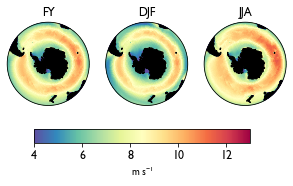

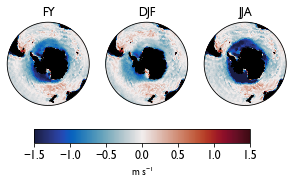

In [149]:
### colorbar for era
fs = 12
seas = ['FY','DJF','JJA']
fig = plt.figure(figsize=[5, 2])
ind = 1
dats = [erafy, eradjf, erajja]
tcm = 'Spectral_r'; botbound = 4; topbound = 13; tint = 2
fnam = './plts-gill/Fig-spat-clim-ERA.jpg'

for tseas in seas:

    ax1 = fig.add_subplot(1, 3, ind, projection=ccrs.Orthographic(0, -90))

    lats = erafy.lat
    lons = erafy.lon

    if ind < 3:
        tcbr = False
    else:
        tcbr = True
    tit = ''
    if ind < 4 :
        tit = f'{tseas}'
    test = dats[ind-1].wspd10m.values
    test = np.squeeze(test)
    bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                  topbound, np.arange(botbound,topbound,tint), fs = fs, 
                  tit =tit, cbarlab = 'm s$^{-1}$', tcmap = tcm, lm = True, cbr = tcbr,\
                      ccoords = [0.2, -0.05, .6, .1])
    ind = ind+1

plt.tight_layout()
fig.savefig(fnam, dpi = 300, bbox_inches='tight')


### colorbar for difference
fig = plt.figure(figsize=[5, 2])
ind = 1
botbound = -1.5; topbound = 1.5; tint = 0.5; tcm = cm.balance
dats = [ncarfy-erafy, ncardjf-eradjf, ncarjja-erajja]
fnam = './plts-gill/Fig-spat-clim-diff.jpg'


for tseas in seas:

    ax1 = fig.add_subplot(1, 3, ind, projection=ccrs.Orthographic(0, -90))

    lats = erafy.lat
    lons = erafy.lon

    if ind < 3:
        tcbr = False
    else:
        tcbr = True
    tit = ''
    if ind < 4 :
        tit = f'{tseas}'
    test = dats[ind-1].wspd10m.values
    test = np.squeeze(test)
    bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                  topbound, np.arange(botbound,topbound,tint), fs = fs, 
                  tit =tit, cbarlab = 'm s$^{-1}$', tcmap = tcm, lm = True, cbr = tcbr,\
                      ccoords = [0.2, -0.05, .6, .1])
    ind = ind+1

plt.tight_layout()
fig.savefig(fnam, dpi = 300, bbox_inches='tight')


## All 15 maps

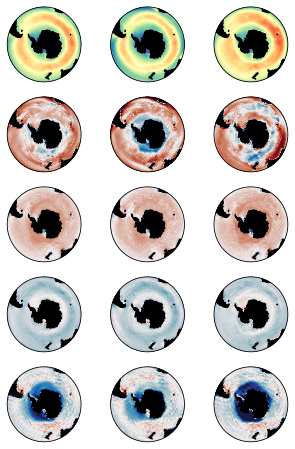

In [150]:
n = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESM',]
fnam = './plts-gill/Fig-spat-clim-maponly.jpg'
# n = ['ERA5']

seas = ['FY','DJF','JJA']

fact = 0.25
fig = plt.figure(figsize=[21*fact, 48/6*4*fact])
tcm = cm.balance



dats = [erafy, eradjf, erajja,\
        ukesmfy-erafy, ukesmdjf-eradjf, ukesmjja-erajja,\
        JRAfy-erafy, JRAdjf-eradjf, JRAjja-erajja,
        merrafy-erafy, merradjf-eradjf, merrajja-erajja, \
        ncarfy-erafy, ncardjf-eradjf, ncarjja-erajja,
       ]
        


botbound = -1.5
topbound = 1.5
tint = 0.5
tcm = cm.balance
tcm2 = 'Spectral_r'
tcbr = True
ind = 1
for tn in n:
    for tseas in seas:
        
        ax1 = fig.add_subplot(5, 3, ind, projection=ccrs.Orthographic(0, -90))

        lats = erafy.lat
        lons = erafy.lon
        
        if ind < 4:
            tcm = 'Spectral_r'
            botbound = 4
            topbound = 13
        
        if ind >=4:
            botbound = -1.5
            topbound = 1.5
            tcm = cm.balance
    
        if ind < 16:
            tcbr = False
            
        else:
            tcbr = True
        tit = ''
        # if ind < 4 :
        #     tit = f'{tseas}'
        test = dats[ind-1].wspd10m.values
        test = np.squeeze(test)
        # test2 = dats2[ind-1].wspd10m.values
        # test2 = np.squeeze(test2)
        # test3 = test2-test
        bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                      topbound, np.arange(botbound,topbound,tint), fs = 14, 
                      tit =tit, cbarlab = 'm/s', tcmap = tcm, lm = True, cbr = tcbr,\
                          ccoords = [0.2, 0.07, .6, .02])
        ind = ind+1
        
plt.tight_layout()
fig.savefig(fnam, dpi = 300, bbox_inches='tight')


## labels

In [ ]:
plt.figure()
n = ['ERA5','R1','MERRA2','JRA3Q','UKESM1',]
wx = np.zeros([6])
wx = np.arange(0.1,1,0.1)
for i in range(0,5):
    #wx[i] = 0.82 - 0.127*i
    plt.text(0.5,wx[i],f'{n[i]}', fontsize = fs, fontproperties=gill_font)
    
plt.savefig('./plts-gill/Fig-spat-clim-labels.jpg',dpi = 300, bbox_inches='tight')
    